<h1 align = "center">Project 1: Latte</h1>

Latte (Let's Absorb Torch Technology Elegantly) is a self-designed deep learning framework working on CPU, the package name shows tribute to Caffe while the inner structure is inspired by the PyTorch framework.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import latte
import latte.nn as nn
import latte.optim as optim
import latte.functional as F
import latte.utils.data as data

import lattevision as lv
import lattevision.datasets as dsets
import lattevision.transforms as T


## 1. Preparation

We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to train our model.

This part of the notebook is mainly about downloading the dataset and preparing it for the model.

### 1.1 Download Dataset

In [2]:
mnist_root = '../data/mnist'
mnist_transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

mnist_train = dsets.MNIST(mnist_root, train=True, transform=mnist_transform)
mnist_test = dsets.MNIST(mnist_root, train=False, transform=mnist_transform)


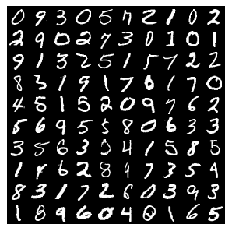

In [3]:
mnist_train.show()


In [4]:
# Split the dataset into training and validation
val_len = len(mnist_train) // 10
train_len = len(mnist_train) - val_len
mnist_train, mnist_val = data.random_split(mnist_train, [train_len, val_len])


In [5]:
len(mnist_train), len(mnist_val), len(mnist_test)


(54000, 6000, 10000)

### 1.2 Load Data

In [6]:
train_batch_size = 128
test_batch_size = 512


In [7]:
train_loader = data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
val_loader = data.DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
test_loader = data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)


In [8]:
for data, target in train_loader:
    print(data.shape, target.shape)
    break


(128, 1, 28, 28) (128,)


## 2. Simple Model

This part of the notebook is mainly about building the linear classifier.

In [9]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [10]:
# Model, criterion, optimizer
toy_model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(toy_model.parameters(), lr=1e-3)


## 3. Training

This part of the notebook is mainly about training the model.

In [11]:
max_epochs = 5
train_losses = []
train_accuracies = []

for epoch in range(max_epochs):
    # Training
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_batchs = 0

    for ii, (data, target) in tqdm(enumerate(train_loader)):
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        # Forward pass
        optimizer.zero_grad()
        output = toy_model(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy

        # Logging
        train_losses.append(loss.data)
        train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}/{max_epochs}')
    print('Training')
    print(
        f'\tLoss: {(epoch_loss / epoch_batchs): .4f} \
        \tAccuracy: {(epoch_accuracy / epoch_batchs): .4f}'
    )

    # Validation
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_batchs = 0
    
    for data, target in val_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        output = toy_model(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy

    print('Validation')
    print(
        f'\tLoss: {(epoch_loss / epoch_batchs): .4f} \
        \tAccuracy: {(epoch_accuracy / epoch_batchs): .4f}'
    )


420it [00:06, 60.05it/s]


Epoch 1/5
Training
	Loss:  0.4030         	Accuracy:  0.8906
Validation
	Loss:  0.2278         	Accuracy:  0.9366


421it [00:06, 64.24it/s]


Epoch 2/5
Training
	Loss:  0.1997         	Accuracy:  0.9506
Validation
	Loss:  0.2005         	Accuracy:  0.9552


421it [00:06, 61.92it/s]


Epoch 3/5
Training
	Loss:  0.1974         	Accuracy:  0.9614
Validation
	Loss:  0.2158         	Accuracy:  0.9599


421it [00:06, 63.93it/s]


Epoch 4/5
Training
	Loss:  0.1904         	Accuracy:  0.9671
Validation
	Loss:  0.2440         	Accuracy:  0.9672


421it [00:06, 64.53it/s]


Epoch 5/5
Training
	Loss:  0.1844         	Accuracy:  0.9716
Validation
	Loss:  0.2643         	Accuracy:  0.9708


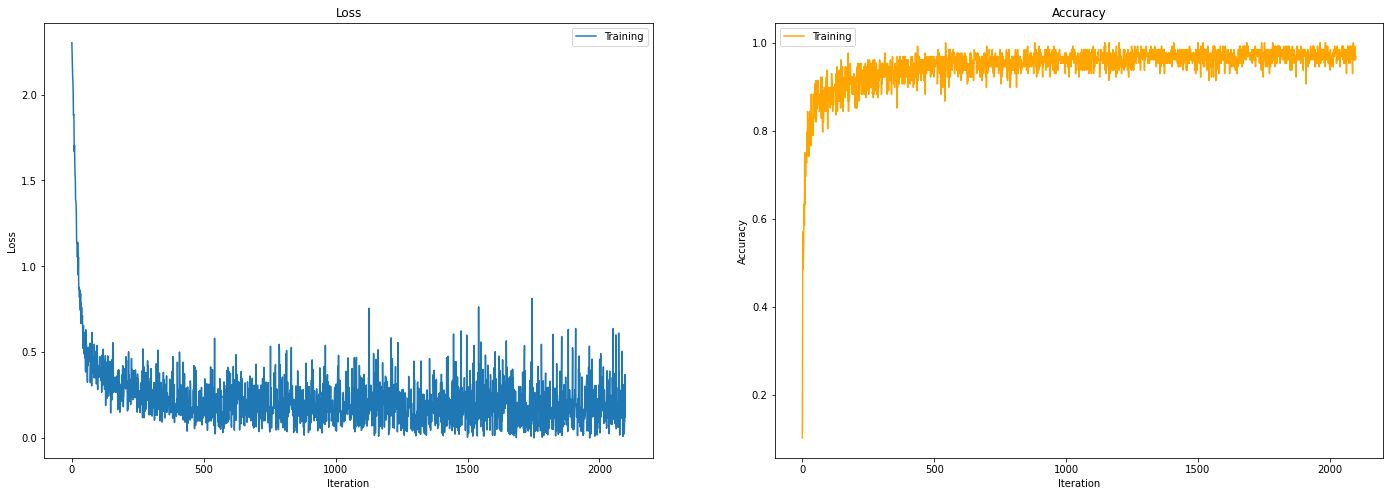

In [12]:
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training', color='orange')
plt.title('Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## 4. Test

This part of the notebook is mainly about testing the model.

In [13]:
# Test
correct = 0
total = 0
for data, target in test_loader:
    batch_size = data.shape[0]
    if batch_size != test_batch_size:
        continue

    data = latte.Tensor(data.reshape(batch_size, -1))
    target = latte.Tensor(target)

    output = toy_model(data)
    correct += (output.data.argmax(axis=1) == target.data).sum()
    total += target.shape[0]

print(f'Accuracy: {correct / total: .4f}')


Accuracy:  0.9701
